## Importing libraries....

In [64]:
# importing libraries....
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import datetime
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import Sequential,layers

In this notebook we're going to predict the prize of the Bitcoin💰.
We'll build a series of model for prediction.

What we're going to cover....???
    ~ Get the data
    ~ Format the data
    ~ Visualize the data
    ~ Prepare data into window size
    ~ Setup a series of model
    ~ Make Prdiction

In [22]:
# getting the data...
!ls

btc_data.csv         btc_prediction.ipynb


In [23]:
df = pd.read_csv("btc_data.csv",parse_dates=["Date"],index_col=["Date"])
df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [24]:
# get some data info
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


In [25]:
df.shape

(2787, 5)

In [26]:
# get the btc price for each day
btc_prices = pd.DataFrame(df["Closing Price (USD)"]).rename(columns={"Closing Price (USD)": "Price"})
btc_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


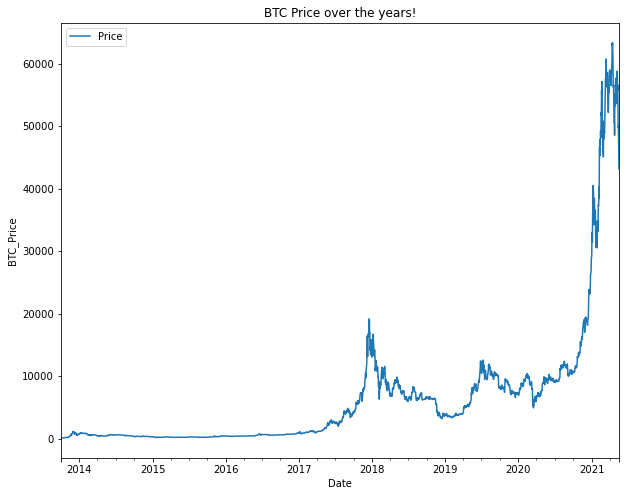

In [27]:
# let's visualize the data...
btc_prices.plot(figsize=(10,8))
plt.ylabel("BTC_Price")
plt.title("BTC Price over the years!")
plt.show()

## Format the data for training and testing...

In [28]:
prices = btc_prices["Price"].to_numpy()
timestamps = btc_prices.index.to_numpy()

In [29]:
# create train and test split 80% for training and 20% testing.....
split_size = int(0.8 * len(btc_prices))

# create train data splits...
X_train,y_train = timestamps[:split_size],prices[:split_size]

# create test data split....
X_test,y_test = timestamps[split_size:],prices[split_size:]

len(X_train),len(y_train),len(X_test),len(y_test)

(2229, 2229, 558, 558)

In [30]:
# let's make a plotting function
def plot_time_series(timestamps,value,format=".",start=0,end=None,label=None):
    plt.plot(timestamps[start:end],value[start:end],format,label=label)
    plt.xlabel("Time")
    plt.ylabel("Price")
    if label:
        plt.legend(fontsize=10)
    plt.grid(True)

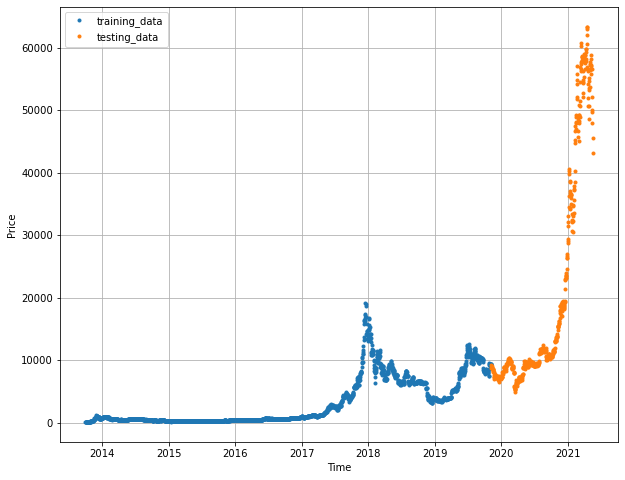

In [31]:
plt.figure(figsize=(10,8))
plot_time_series(X_train,y_train,label="training_data")
plot_time_series(X_test,y_test,label="testing_data")

## Modelling Experiments:

We're going to build a plenty of models that will predict the bitcoin price using historical data.

## Model 0 : Naive Forecast

Naive model is one of the most common model for time series probles. It predicts the price by y(pred) = y(t-1).

In [32]:
# create a naive forecast...
naive_forecast = y_test[:-1]

naive_forecast[:10] , naive_forecast[-10:]

(array([9226.48582088, 8794.35864452, 8798.04205463, 9081.18687849,
        8711.53433917, 8760.89271814, 8749.52059102, 8656.97092235,
        8500.64355816, 8469.2608989 ]),
 array([57107.12067189, 58788.20967893, 58102.19142623, 55715.54665129,
        56573.5554719 , 52147.82118698, 49764.1320816 , 50032.69313676,
        47885.62525472, 45604.61575361]))

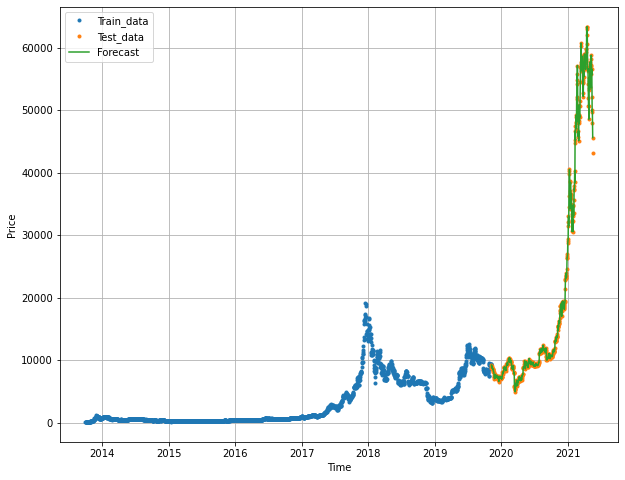

In [33]:
# plot naive forecast....
plt.figure(figsize=(10,8))
plot_time_series(X_train,y_train,label="Train_data")
plot_time_series(X_test,y_test,label="Test_data")
plot_time_series(X_test[1:],naive_forecast,format="-",label="Forecast")

## Evaluate a time series model...

In [39]:
def mean_absolute_scaled_error(y_true,y_pred):
    
    import tensorflow as tf
    mae = tf.reduce_mean(tf.abs(y_true - y_pred))
    
#     find mae for naive forecast
    mae_navie_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1]))
    return mae / mae_navie_no_season

# let's make a function that will evaluate our predictions....

def evaluate_preds(y_true,y_pred):
#     make sure they're in float 32
    import tensorflow as tf
    y_true = tf.cast(y_true,dtype=tf.float32)
    y_pred = tf.cast(y_pred,dtype=tf.float32)
    
    
#     calculate various metrics....
    mae = tf.keras.metrics.mean_absolute_error(y_true,y_pred)
    mse = tf.keras.metrics.mean_squared_error(y_true,y_pred)
    rmse = tf.sqrt(mse)
    mape = tf.keras.metrics.mean_absolute_percentage_error(y_true,y_pred)
    mase = mean_absolute_scaled_error(y_true,y_pred)
    
    results = {
        "MAE" : mae.numpy(),
        "MSE" : mse.numpy(),
        "RMSE" : rmse.numpy(),
        "MAPE" : mape.numpy(),
        "MASE" : mase.numpy(),
    }
    return results

In [41]:
naive_results = evaluate_preds(y_test[1:],naive_forecast)
naive_results

{'MAE': 567.9803,
 'MSE': 1147547.1,
 'RMSE': 1071.2362,
 'MAPE': 2.516525,
 'MASE': 0.99957013}

## Format Data into window

Now we're turning our data into window and horizon. Window is a method to turn time series dataset for machine learning modelling. For example window = 7 and horizon =1 means we're using past 7 days data to predict 1 day btc price. let's see in action

In [42]:
# setup window and horizon size
HORIZON = 1
WINDOW = 7 

In [44]:
def get_label_window(x,horizon):
    
    return x[:,:-horizon], x[:,-horizon:]

In [52]:
# test it out 
test_window, test_label = get_label_window(tf.expand_dims(tf.range(8)+1,axis=1),1)
test_window.numpy(),test_label.numpy()

(array([], shape=(8, 0), dtype=int32),
 array([[1],
        [2],
        [3],
        [4],
        [5],
        [6],
        [7],
        [8]], dtype=int32))

In [55]:
def make_windows(x,windows = 7,horizon = 1):
    
    window_step = np.expand_dims(np.arange(windows+horizon),axis=0)
    
    window_indexes = window_step + np.expand_dims(np.arange(len(x) - (windows+horizon - 1)), axis = 0 ).T
    
    windowed_array = x[window_indexes]
    
    windows,label = get_label_window(windowed_array,horizon)
    
    return windows,label

In [57]:
# check it out....
full_windows,full_labels = make_windows(prices,)
len(full_windows),len(full_labels)

(2780, 2780)

In [58]:
for i in range(3):
    print(full_windows[i],full_labels[i])

[123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] [123.033]
[125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ] [124.049]
[108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ] [125.96116]


In [60]:
# make a function for train and test split
def train_test_split(window,label,):
    split_size = int(len(window) * 0.8)
    train_windows = window[:split_size]
    train_labels = label[:split_size]
    test_windows = window[split_size:]
    test_labels = label[split_size:]
    return train_windows,test_windows,train_labels,test_labels

In [61]:
train_windows,test_windows,train_labels,test_labels = train_test_split(full_windows,full_labels)
len(train_windows),len(train_labels),len(test_windows),len(test_labels)

(2224, 2224, 556, 556)

In [63]:
# make model check point..
def create_model_checkpoint(model_name,path="model_experiments"):
    data_dir = path + "/" + model_name + "/" + datetime.datetime.now().strftime("%Y%m%d%H%M")
    check_p = TensorBoard(data_dir)
    print(f"Model Saving to : {data_dir}")
    return check_p

## Model 1 : Dense Model 
we're going to build our first dense model with window size = 7 and horizon = 1.

In [71]:
# let's build dense model...
tf.random.set_seed(42)

# construct model 
model_1 = Sequential(name="model_1")
model_1.add(layers.Dense(128,activation="relu"))
model_1.add(layers.Dense(HORIZON,activation="linear"))

# compile the model
model_1.compile(loss="mae",
               optimizer=tf.keras.optimizers.Adam(),
               metrics=["mae"])

# fit the model
history_1 = model_1.fit(train_windows,train_labels,epochs=100,batch_size=128,
                       validation_data=(test_windows,test_labels),
                       callbacks=[create_model_checkpoint("model_1")])

Model Saving to : model_experiments/model_1/202208222303
Epoch 1/100


2022-08-22 23:03:54.067975: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-08-22 23:03:54.255656: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 1s 16ms/step - loss: 780.3450 - mae: 780.3450 - val_loss: 2279.6550 - val_mae: 2279.6550
Epoch 2/100
18/18 [==============================] - 0s 6ms/step - loss: 247.6752 - mae: 247.6752 - val_loss: 1006.0009 - val_mae: 1006.0009
Epoch 3/100
14/18 [======================>.......] - ETA: 0s - loss: 192.5418 - mae: 192.5418

2022-08-22 23:03:54.953085: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 0s 6ms/step - loss: 188.4117 - mae: 188.4117 - val_loss: 923.2863 - val_mae: 923.2862
Epoch 4/100
18/18 [==============================] - 0s 6ms/step - loss: 169.4341 - mae: 169.4341 - val_loss: 900.5866 - val_mae: 900.5865
Epoch 5/100
18/18 [==============================] - 0s 6ms/step - loss: 165.0894 - mae: 165.0894 - val_loss: 895.2215 - val_mae: 895.2215
Epoch 6/100
18/18 [==============================] - 0s 6ms/step - loss: 158.5210 - mae: 158.5210 - val_loss: 855.1998 - val_mae: 855.1998
Epoch 7/100
18/18 [==============================] - 0s 6ms/step - loss: 151.3567 - mae: 151.3567 - val_loss: 840.9153 - val_mae: 840.9153
Epoch 8/100
18/18 [==============================] - 0s 6ms/step - loss: 145.2561 - mae: 145.2561 - val_loss: 803.5953 - val_mae: 803.5953
Epoch 9/100
18/18 [==============================] - 0s 6ms/step - loss: 144.3546 - mae: 144.3546 - val_loss: 799.5440 - val_mae: 799.5440
Epoch 10/100
18/18 [===================

18/18 [==============================] - 0s 5ms/step - loss: 108.1524 - mae: 108.1524 - val_loss: 573.9989 - val_mae: 573.9989
Epoch 62/100
18/18 [==============================] - 0s 5ms/step - loss: 107.3727 - mae: 107.3727 - val_loss: 581.7037 - val_mae: 581.7037
Epoch 63/100
18/18 [==============================] - 0s 5ms/step - loss: 110.7667 - mae: 110.7667 - val_loss: 637.5209 - val_mae: 637.5209
Epoch 64/100
18/18 [==============================] - 0s 5ms/step - loss: 110.1539 - mae: 110.1539 - val_loss: 586.6582 - val_mae: 586.6582
Epoch 65/100
18/18 [==============================] - 0s 5ms/step - loss: 108.2324 - mae: 108.2324 - val_loss: 573.5630 - val_mae: 573.5630
Epoch 66/100
18/18 [==============================] - 0s 5ms/step - loss: 108.6826 - mae: 108.6826 - val_loss: 572.2212 - val_mae: 572.2212
Epoch 67/100
18/18 [==============================] - 0s 5ms/step - loss: 106.6343 - mae: 106.6343 - val_loss: 647.4645 - val_mae: 647.4645
Epoch 68/100
18/18 [=============

In [73]:
# evalute our model
model_1.evaluate(test_windows,test_labels)

18/18 [==============================] - 0s 9ms/step - loss: 589.9119 - mae: 589.9119


[589.911865234375, 589.911865234375]

In [74]:
# make a function for prediction
def make_preds(model,data):
    pred = model.predict(data)
    return tf.squeeze(pred)

In [75]:
# make prediction...
model_1_pred = make_preds(model_1,test_windows)
model_1_pred

18/18 [==============================] - 0s 2ms/step


2022-08-22 23:14:47.312605: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


<tf.Tensor: shape=(556,), dtype=float32, numpy=
array([ 8794.223 ,  8706.797 ,  8961.296 ,  8741.508 ,  8663.25  ,
        8666.623 ,  8632.853 ,  8444.614 ,  8397.16  ,  8460.887 ,
        8199.932 ,  8051.6123,  7999.487 ,  7637.419 ,  7229.345 ,
        7206.5957,  7050.6855,  7131.563 ,  7095.811 ,  7423.9907,
        7355.9688,  7653.485 ,  7524.2783,  7384.0645,  7269.0825,
        7273.947 ,  7177.659 ,  7304.6973,  7442.3003,  7489.825 ,
        7496.807 ,  7323.1533,  7201.231 ,  7139.8906,  7142.9316,
        7172.9194,  7055.815 ,  7049.6147,  6859.538 ,  6577.152 ,
        7228.3027,  7192.351 ,  7105.659 ,  7184.599 ,  7250.824 ,
        7127.5674,  7165.8867,  7173.975 ,  7138.9487,  7162.9443,
        7253.562 ,  7330.251 ,  7223.555 ,  7138.939 ,  7120.764 ,
        6943.0176,  7177.119 ,  7281.7793,  7313.2725,  7605.075 ,
        7982.7344,  8056.524 ,  7812.53  ,  8013.463 ,  8052.0117,
        8103.3623,  8052.0215,  8614.301 ,  8803.383 ,  8714.823 ,
        8840.7

In [77]:
# let's evaluate our model
model_1_results = evaluate_preds(tf.squeeze(test_labels),model_1_pred)
model_1_results

{'MAE': 589.91187,
 'MSE': 1204430.1,
 'RMSE': 1097.4653,
 'MAPE': 2.6385434,
 'MASE': 1.0363115}

In [78]:
# did it beat the naive model
naive_results

{'MAE': 567.9803,
 'MSE': 1147547.1,
 'RMSE': 1071.2362,
 'MAPE': 2.516525,
 'MASE': 0.99957013}

## Model 2 : Dense

Let's build our 2nd dense model with window size = 30 and horizon = 1. means we're using monthly data to predict one bitcoin price.

In [80]:
HORIZON = 1
WINDOW = 30

# make data sets...
full_windows,full_labels  = make_windows(prices,WINDOW,HORIZON)
train_windows,test_windows,train_labels,test_labels = train_test_split(full_windows,full_labels)
len(train_windows),len(train_labels),len(test_windows),len(test_labels)

(2205, 2205, 552, 552)

In [81]:
# let's construct the model
# setup the random seed
tf.random.set_seed(42)

# construct the model
model_2 = Sequential(name="model_2")
model_2.add(layers.Dense(128,activation="relu"))
model_2.add(layers.Dense(HORIZON,activation="linear"))

# compile the model
model_2.compile(loss="mae",
               optimizer=tf.keras.optimizers.Adam(),
               metrics=["mae"])

# fit the model
history_2 = model_2.fit(train_windows,train_labels,epochs=100,batch_size=128,
                       validation_data=(test_windows,test_labels),
                       callbacks=[create_model_checkpoint("model_2_dense")])

Model Saving to : model_experiments/model_2_dense/202208222324
Epoch 1/100
15/18 [========================>.....] - ETA: 0s - loss: 1139.7314 - mae: 1139.7314

2022-08-22 23:24:19.193328: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 0s 13ms/step - loss: 1097.0399 - mae: 1097.0399 - val_loss: 3900.2065 - val_mae: 3900.2065
Epoch 2/100
18/18 [==============================] - 0s 5ms/step - loss: 428.0732 - mae: 428.0732 - val_loss: 1587.0874 - val_mae: 1587.0874
Epoch 3/100
10/18 [===============>..............] - ETA: 0s - loss: 302.3531 - mae: 302.3531

2022-08-22 23:24:19.505127: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 0s 6ms/step - loss: 279.7657 - mae: 279.7657 - val_loss: 1220.6958 - val_mae: 1220.6958
Epoch 4/100
18/18 [==============================] - 0s 5ms/step - loss: 224.3639 - mae: 224.3639 - val_loss: 1160.1470 - val_mae: 1160.1470
Epoch 5/100
18/18 [==============================] - 0s 6ms/step - loss: 187.9680 - mae: 187.9680 - val_loss: 1007.6438 - val_mae: 1007.6438
Epoch 6/100
18/18 [==============================] - 0s 5ms/step - loss: 182.9174 - mae: 182.9174 - val_loss: 1019.5895 - val_mae: 1019.5895
Epoch 7/100
18/18 [==============================] - 0s 6ms/step - loss: 187.7610 - mae: 187.7610 - val_loss: 1145.1880 - val_mae: 1145.1880
Epoch 8/100
18/18 [==============================] - 0s 6ms/step - loss: 192.2205 - mae: 192.2205 - val_loss: 967.7980 - val_mae: 967.7980
Epoch 9/100
18/18 [==============================] - 0s 5ms/step - loss: 167.4042 - mae: 167.4042 - val_loss: 896.5208 - val_mae: 896.5208
Epoch 10/100
18/18 [=========

18/18 [==============================] - 0s 5ms/step - loss: 126.1348 - mae: 126.1348 - val_loss: 672.2117 - val_mae: 672.2117
Epoch 62/100
18/18 [==============================] - 0s 5ms/step - loss: 130.4214 - mae: 130.4214 - val_loss: 801.4264 - val_mae: 801.4264
Epoch 63/100
18/18 [==============================] - 0s 5ms/step - loss: 127.6032 - mae: 127.6032 - val_loss: 639.7857 - val_mae: 639.7857
Epoch 64/100
18/18 [==============================] - 0s 5ms/step - loss: 124.4576 - mae: 124.4576 - val_loss: 737.6666 - val_mae: 737.6666
Epoch 65/100
18/18 [==============================] - 0s 5ms/step - loss: 127.4750 - mae: 127.4750 - val_loss: 634.6021 - val_mae: 634.6021
Epoch 66/100
18/18 [==============================] - 0s 5ms/step - loss: 121.9509 - mae: 121.9509 - val_loss: 632.6848 - val_mae: 632.6848
Epoch 67/100
18/18 [==============================] - 0s 5ms/step - loss: 122.7524 - mae: 122.7524 - val_loss: 642.1250 - val_mae: 642.1250
Epoch 68/100
18/18 [=============

In [82]:
# let's evaluate our model....
model_2.evaluate(test_windows,test_labels)

18/18 [==============================] - 0s 8ms/step - loss: 605.8130 - mae: 605.8130


[605.81298828125, 605.81298828125]

In [84]:
# let's make predictions...
model_2_pred = make_preds(model_2,test_windows)
model_2_pred[:10]

18/18 [==============================] - 0s 2ms/step


2022-08-22 23:25:31.789674: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8873.3545, 8892.45  , 8752.066 , 8544.906 , 8408.22  , 8308.76  ,
       8239.076 , 8113.9067, 8159.001 , 7775.4316], dtype=float32)>

In [86]:
# calculate the results....
model_2_results = evaluate_preds(tf.squeeze(test_labels),model_2_pred)
model_2_results

{'MAE': 605.813,
 'MSE': 1265319.5,
 'RMSE': 1124.8641,
 'MAPE': 2.7242374,
 'MASE': 1.058967}